# Exercise 5 - Python: Regularized Linear Regression and Bias vs. Variance

## *Part I*: Regularized Linear Regression

Predicting the amount of water flowing out of a dam using the change of water level in a reservoir

Part I is primarily setup for creating a regularized logistic regression model before diving into the new concepts for this exercise

---

Beginning with package imports, data loading, and initial visualization

In [1]:
import numpy as np
import pandas as pd
import altair  # Data visualization
from altair import Chart, LayeredChart  # Used to define plot objects
import scipy.io as sio  # Used to load the Octave/MATLAB *.mat files
from scipy import optimize

In [2]:
# Reading in the .mat file
data = sio.loadmat('ex5/ex5data1.mat')

# Unpacking values from the .mat file
# Training set for fitting the models
X = data['X']
y = data['y']

# Validation set for determining the regularization parameter
Xval = data['Xval']
yval = data['yval']

# Test set for evaluating performance
Xtest = data['Xtest']
ytest = data['ytest']

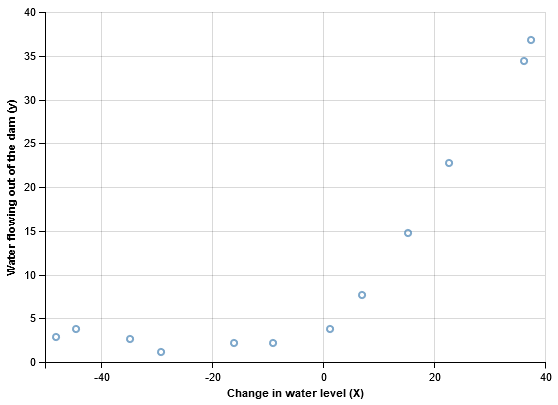

In [3]:
# Creating a data frame since altair requires it as input
df = pd.DataFrame({'X': X.flatten(), 'y': y.flatten()})

# Plotting the data
Chart(df).mark_point().encode(
    x=altair.X('X:Q', axis=altair.Axis(title='Change in water level (X)')),
    y=altair.Y('y:Q', axis=altair.Axis(title='Water flowing out of the dam (y)')))

### Regularized cost function

$J(\theta) = \frac{1}{2m} \big(\sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})^2 \big) + \frac{\lambda}{2m} \big( \sum_{j=1}^n \theta_j^2 \big)$

In [4]:
def cost_function(theta, X, y, C=0.0):
    """
    Calculates the cost for regularized linear regression
    """
    m = y.size
    
    # Adding the intercept term if it doesn't exist
    if X.shape[1] == 1 or X[:, 0].mean() != 0:
        X = np.insert(X, 0, 1, axis=1)
    
    h = X.dot(theta.reshape(-1, 1))  # Generating predictions
    error = np.sum((h - y)**2)  # Calculating squared error
    regParam = (C/(2*m)) * np.sum(np.power(theta[1:], 2))
    
    J = (1/(2*m)) * error + regParam  # Calculating total cost
    
    return J

# Initial values to test our functions and use for theta optimization
initialTheta = np.ones(2)

cost_function(initialTheta, X, y, 1.0)

303.99319222026429

### Regularized gradient

$\frac{\partial J(\theta)}{\partial \theta_j} = \begin{cases} 
\hspace{0.25cm} \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} & \text{for}\ j = 0 \\
\Big(\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}\Big) + \frac{\lambda}{m}\theta_j & \text{for}\ j \geq 1
\end{cases}$

In [5]:
def gradient(theta, X, y, C=0.0):
    """
    Calculates the gradient for regularized linear regression
    """
    m = y.size
    
    # Adding the intercept term if it doesn't exist
    if X.shape[1] == 1 or X[:, 0].mean() != 1:
        X = np.insert(X, 0, 1, axis=1)
        
    h = X.dot(theta.reshape(-1, 1))

    # Calculating the regularization parameter for all thetas but the intercept
    regParam = (C/m)*theta[1:]
    
    gradient = (1/m)*(X.T.dot(h-y))
    gradient[1:] = gradient[1:] + regParam  # Applying the reg parameter
    return gradient


gradient(initialTheta, X, y, 1.0)

array([[ -15.30301567],
       [ 598.25074417]])

### Fitting linear regression

In [6]:
def fit_model(thetas, X, y, C=0.0):
    """
    Helper function for optimizing the thetas for the regularized
    linear regression model
    """
    # Finding values of theta that minimize the cost function
    fitted = optimize.fmin(func=cost_function,  # Function to minimize
                           x0=thetas,  # Initial guess
                           args=(X, y, C),  # Additional Arguments
                           maxiter=4000,
                           disp=False)  # Removes # iterations performed
    return fitted


optimalTheta = fit_model(initialTheta, X, y)
optimalTheta

array([ 13.08791065,   0.36778096])

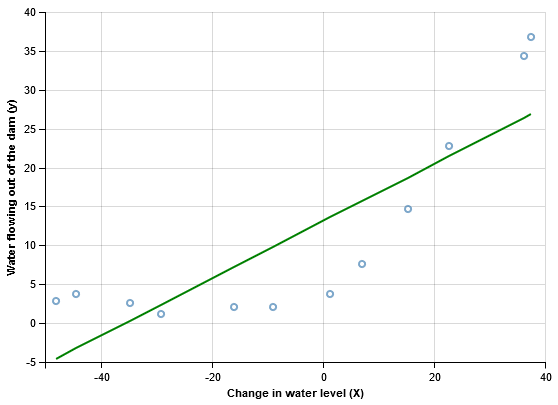

In [7]:
# Generating predictions
df['Prediction'] = optimalTheta[0] + df['X'] * optimalTheta[1]

# Creating the initial object for layering charts
chart = LayeredChart(df)

# Plotting original data
chart += Chart(df).mark_point().encode(
            x=altair.X('X:Q', axis=altair.Axis(title='Change in water level (X)')),
            y=altair.Y('y:Q', axis=altair.Axis(title='Water flowing out of the dam (y)')))

# Adding the fitting line
chart += Chart(df).mark_line(color='green').encode(
            x='X:Q',
            y='Prediction:Q')

# Rendering the output
chart.display()

---

##  *Part II:* Bias-Variance

The [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) is a ubiquitous problem in machine learning for getting models to generalize beyond their training set.  At its core, it is a way to see if a model is over or underfitting, and it is a diagnostic that can help determine how to improve the model (e.x. gather more samples, gather other features, remove features, etc.).  Here are the definitions on bias and variance

- **Bias:**  Error from erroneous assumptions in the learning algorithm.  High bias can cause an algorithm to miss the relevant relations between features and target outputs (*underfitting*)

- **Variance:** Error from sensitivity to small fluctuations in the training set.  High variance can cause *overfitting*: modeling the random noise in the training data, rather than the intended outputs

If you're a visual learner like myself, here's a common visualization to describe bias and variance:

<img src="http://www.kdnuggets.com/wp-content/uploads/bias-and-variance.jpg" style="width: 350px">

To reiterate, a high bias leads to overfitting, and a high variance leads to underfitting.  Trying to minimize both tends to result in a good generalized fit that will perform well on data that the model hasn't seen before.

[This blog post](http://scott.fortmann-roe.com/docs/BiasVariance.html) also does an exceptional job at explaining the bias-variance tradeoff in further detail.

### Learning curves

Learning curves are an excellent way to show the bias and variance of our model.  They are a graph of the error of both the validation set and the training set by the number of training examples.  The shape of these errors will help us deduce the bias/variance of the model.  Here are examples showing the cases of high/low bias/variance (note: this is a transposed version of the targets shown above):

<img src="http://www.ultravioletanalytics.com/wp-content/uploads/2014/12/bias_variance_chart1.jpg"style="width: 450px">

For reference, here are the cost functions to be used in the learning curves.  Note that the cost in the training set only applies to the records that it has seen up until that point, but the cost on the validation set applies to the entire validation set:

$$J_{train}(\theta) = \frac{1}{2m} \big[ \sum_{i=1}^m (h_{\theta}(x^{(o)})-y^{(i)})^2 \big]$$

$$J_{validation}(\theta) = \frac{1}{2m_{validation}} \big[ \sum_{i=1}^{m_{validation}} (h_{\theta}(x_{validation}^{(o)})-y_{validation}^{(i)})^2 \big]$$

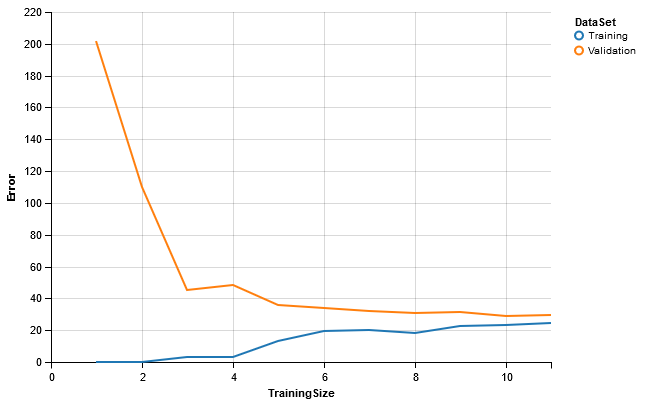

In [8]:
def plot_learning_curve(Xtrain, ytrain, Xval, yval, C=0.0):
    """
    Plots the learning curve of the regularized logistic regression 
    """
    m = ytrain.size

    # Creating empty lists to add the error to
    trainingError = []
    validationError = []

    # Looping through training sizes to calculate our errors
    for i in range(1, m):

        # Optimizing theta with the given training size
        thetas = fit_model(np.zeros(Xtrain.shape[1]+1), Xtrain[:i], ytrain[:i], C)

        # Calculating the training error
        trainingError.append(cost_function(thetas, Xtrain[:i], ytrain[:i],
                                           0))  # Excluding reg parameter

        # Calculating the validation error
        validationError.append(cost_function(thetas, Xval, yval,
                                             0))  # Excluding reg parameter

    # Storing the training error in a data frame
    results = pd.DataFrame(trainingError, columns=['Error'])
    results['DataSet'] = 'Training'
    results['TrainingSize'] = range(1, m)

    # Storing the validation error in a data frame
    validation = pd.DataFrame(validationError, columns=['Error'])
    validation['DataSet'] = 'Validation'
    validation['TrainingSize'] = range(1, m)

    # Joining the two into one data frame
    results = results.append(validation, ignore_index=True)

    # Plotting the data
    learning_curve = Chart(results).mark_line().encode(
        x='TrainingSize:Q',
        y='Error:Q',
        color='DataSet:N')

    return learning_curve


plot_learning_curve(X, y, Xval, yval)

This model is suffering from high bias, which we could have inferred from plotting the fitting curve in the first section

---

##  *Part III:* Polynomial Regression

Since our initial fit had a very high bias, we'll introduce polynomial terms to obtain a better fit that reduces the bias

We also have to normalize our features when introducing the polynomial terms, which we'll do with standard scaling.  This results in each column having a mean of 0 and a standard deviation of 1.  As a reminder, the formula is $$x' = \frac{x - \bar{x}}{\sigma}$$

In [9]:
def map_polynomial(X, order):
    """
    Maps X up to the polynomial order specified
    """
    Xpoly = X.copy()

    if order <= 1:
        return X

    for i in range(2, order + 1):
        Xpoly = np.insert(arr=Xpoly, obj=i - 1,
                          values=np.power(X.flatten(), i), axis=1)

    return Xpoly


power = 6
print('Polynomial size:', map_polynomial(X, power).shape)


def standard_scale(Xtrain, Xval, Xtest):
    """
    Modifies each column to have a mean of 0 and a standard deviation of 1
    Takes train/validation/test sets to same scaling is applied to all of them

    Returns:
    0: Training set (normalized)
    1: Validation set (normalized)
    2: Testing set (normalized)
    """

    # Gathering parameters from X train
    Xbar = np.mean(Xtrain, axis=0)
    sigma = np.std(Xtrain, axis=0, ddof=1)

    # Applying the scaling to all data sets
    Xtrain_norm = (Xtrain - Xbar) / sigma
    Xval_norm = (Xval - Xbar) / sigma
    Xtest_norm = (Xtest - Xbar) / sigma

    return Xtrain_norm, Xval_norm, Xtest_norm


def preprocess_features(Xtrain, Xval, Xtest, order=1):
    """
    A convenience function that performs the previous two functions

    Returns:
    0: Training set (normalized)
    1: Validation set (normalized)
    2: Testing set (normalized)
    """

    # Mapping the polynomial terms
    Xtrain = map_polynomial(Xtrain, order)
    Xval = map_polynomial(Xval, order)
    Xtest = map_polynomial(Xtest, order)

    # Applying standard scaling
    return standard_scale(Xtrain, Xval, Xtest)


# Checking that the mean of each column in X is 0
np.mean(preprocess_features(X, Xval, Xtest, 4)[0], axis=0)

Polynomial size: (12, 6)


array([ -6.47630098e-17,   2.35922393e-16,   5.55111512e-17,
        -4.62592927e-17])

### Fitting

We'll try polynomial terms up until the order of 4 and see what the fit looks like

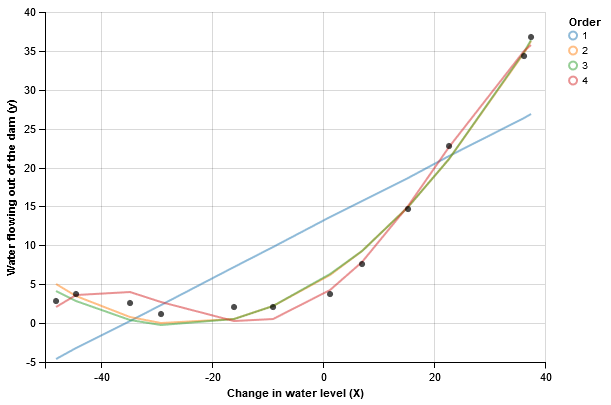

In [10]:
polynomial_orders = 4

# Copying the data frame to be filled for the plot
dfPoly = df.copy()

# Generating predictions for the orders specified
for order in range(2, polynomial_orders + 1):
    Xpoly = preprocess_features(X, Xval, Xtest, order)[0]
    optimalTheta = fit_model(np.zeros(order + 1), Xpoly, y)
    prediction = optimalTheta[0] + np.sum(optimalTheta[1:] * Xpoly, axis=1)
    dfPoly = dfPoly.append(pd.DataFrame(
        {'Prediction': prediction, 'X': X.flatten(), 'Order': order}))

dfPoly['Order'].fillna(1, inplace=True)

# Creating the initial object for layering charts
chart = LayeredChart(dfPoly)

# Plotting the fitting lines
chart += Chart(dfPoly).mark_line(opacity=0.5).encode(
    x=altair.X('X:Q', axis=altair.Axis(title='Change in water level (X)')),
    y=altair.Y('Prediction:Q', axis=altair.Axis(
        title='Water flowing out of the dam (y)')),
    color='Order:N')

# Plotting original data
chart += Chart(dfPoly).mark_circle(color='black').encode(
    x='X:Q',
    y='y:Q')

# Rendering the output
chart.display()

Plotting the learning curve of the second order polynomials:

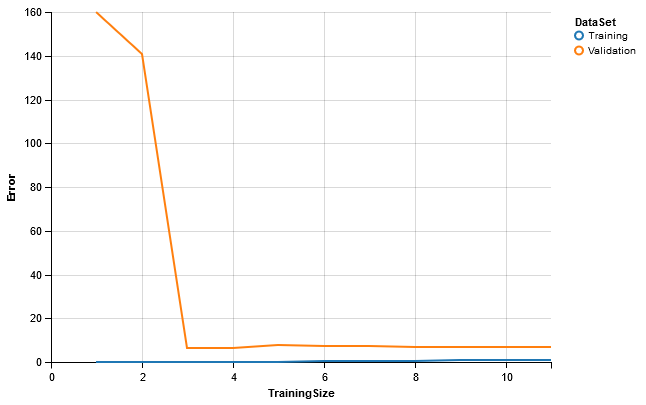

In [11]:
polynomial_orders = 2

# Plotting the learning curve
processed_features = preprocess_features(
    X, Xval, Xtest, order=polynomial_orders)
plot_learning_curve(processed_features[0], y, processed_features[1], yval)

The gap between the training error and the validation error indicates a high variance problem, which can potentially be solved with regularization

### Adjusting the regularization parameter

We're going to look at the fitting lines of a few different values of lambda, and review the learning curve to see if the variance problem is fixed 

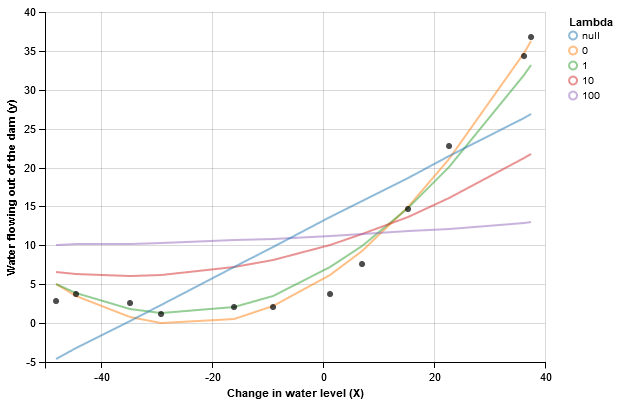

In [12]:
polynomial_orders = 2

# Copying the data frame to be filled for the plot
dfReg = df.copy()

# Generating the polynomial features for the training set
Xpoly = preprocess_features(X, Xval, Xtest, order=polynomial_orders)[0]

# Looping through different values of lambda
for C in [0, 1, 10, 100]:
    optimalTheta = fit_model(np.zeros(polynomial_orders + 1), Xpoly, y, C)
    prediction = optimalTheta[0] + np.sum(optimalTheta[1:] * Xpoly, axis=1)
    dfReg = dfReg.append(pd.DataFrame(
        {'Prediction': prediction, 'X': X.flatten(), 'Lambda': C}))


# Creating the initial object for layering charts
chart = LayeredChart(dfReg)

# Plotting the fitting lines
chart += Chart(dfReg).mark_line(opacity=0.5).encode(
    x=altair.X('X:Q', axis=altair.Axis(title='Change in water level (X)')),
    y=altair.Y('Prediction:Q', axis=altair.Axis(
        title='Water flowing out of the dam (y)')),
    color='Lambda:N')

# Plotting original data
chart += Chart(dfReg).mark_circle(color='black').encode(
    x='X:Q',
    y='y:Q')

# Rendering the output
chart.display()

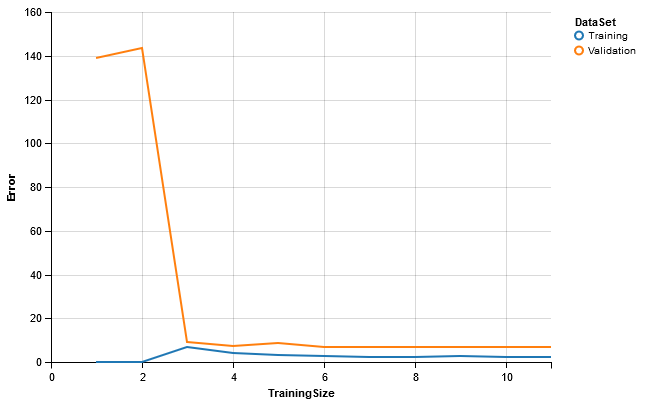

In [13]:
# Plotting the learning curve
processed_features = preprocess_features(
    X, Xval, Xtest, order=polynomial_orders)

plot_learning_curve(processed_features[0], y,
                    processed_features[1], yval, C=1)

There's now a wider gap between the two which indicates that our variance has lowered

### Selecting $\lambda$ using a cross validation set

Here we will evaluate the error on our $\lambda$ values by plotting a validation curve.  This is a way to evaluate error as a function of model complexity.

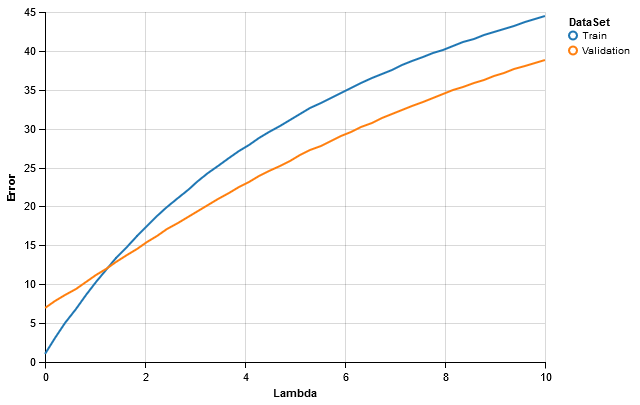

In [14]:
polynomial_orders = 2

# Creating empty lists to fill to create a data frame
trainError = []
validationError = []

# Creating the polynomial features
processed_features = preprocess_features(
    X, Xval, Xtest, order=polynomial_orders)
Xpoly = processed_features[0]
Xvalpoly = processed_features[1]

# Looping through lambda values to obtain error
lambdas = np.linspace(0, 10)
for C in lambdas:
    optimalTheta = fit_model(np.zeros(Xpoly.shape[1] + 1), Xpoly, y, C)
    trainError.append(cost_function(optimalTheta, Xpoly, y, C))
    validationError.append(cost_function(optimalTheta, Xvalpoly, yval, C))

# Putting the results into data frames
results = pd.DataFrame(
    {'Error': trainError, 'Lambda': lambdas, 'DataSet': 'Train'})
validation = pd.DataFrame(
    {'Error': validationError, 'Lambda': lambdas, 'DataSet': 'Validation'})
results = results.append(validation)

# Plotting the validation curve
Chart(results).mark_line().encode(
    x='Lambda:Q',
    y='Error:Q',
    color='DataSet:N')

According to the validation curve, a $\lambda \in [2,3]$ are the optimal choices